In [11]:
# Dataset Name: UCLA Textbook Dataset
# Dataset Location: https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb
# Date Started: 11/25/2020
# Algorithm: Bayesian Networks

# Goal: Learn about summing out and products of probability tables. Do some marginalization/reduction/multiplication on custom DiscreteFactors

# Attribute Information:
# Winter; true, false
# Sprinkler; true, false
# Rainy; true, false
# Wet Grass; true, false
# Slippery Road; true, false

# Imports for Probablistic graphical models and Bayesian Networks
import networkx as nx
import pylab
!pip install pgmpy
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination

# How the progress bar is done
from tqdm import trange

# Standard Machine Learning Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

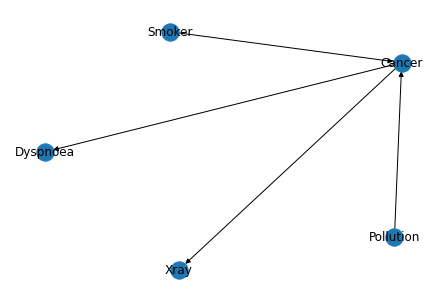

In [12]:
# Load in information about the model from the source

# Define the Cancer Model
cancer_model = BayesianModel([('Pollution', 'Cancer'),
                              ('Smoker', 'Cancer'),
                              ('Cancer', 'Xray'),
                              ('Cancer', 'Dyspnoea')])

# Create CPDS
from pgmpy.factors.discrete import TabularCPD

cpd_poll = TabularCPD(variable='Pollution', variable_card=2,
                      values=[[0.9], [0.1]])
cpd_smoke = TabularCPD(variable='Smoker', variable_card=2,
                       values=[[0.3], [0.7]])
cpd_cancer = TabularCPD(variable='Cancer', variable_card=2,
                        values=[[0.03, 0.05, 0.001, 0.02],
                                [0.97, 0.95, 0.999, 0.98]],
                        evidence=['Smoker', 'Pollution'],
                        evidence_card=[2, 2])
cpd_xray = TabularCPD(variable='Xray', variable_card=2,
                      values=[[0.9, 0.2], [0.1, 0.8]],
                      evidence=['Cancer'], evidence_card=[2])
cpd_dysp = TabularCPD(variable='Dyspnoea', variable_card=2,
                      values=[[0.65, 0.3], [0.35, 0.7]],
                      evidence=['Cancer'], evidence_card=[2])


# Associating the parameters with the model structure.
cancer_model.add_cpds(cpd_poll, cpd_smoke, cpd_cancer, cpd_xray, cpd_dysp)

# Draw the Model for visualization 
nx.draw(cancer_model, with_labels=True)
pylab.show()

In [48]:
class DiscreteFactor_v1():

  def __init__(self, variables, variable_card, phi_values, state_names=None):

    self.variables = variables
    from itertools import permutations, combinations
    # Make the discrete factor dataframe
    if not state_names:
      all_values_seperated=[]
      all_values_list=[]
      for var, card in zip(self.variables, variable_card):
        var_values = [var+"_"+str(num) for num in range(card)]
        all_values_seperated.append(var_values)
        for value in var_values:
          all_values_list.append(value)
    self.all_values_seperated = all_values_seperated.copy()

    # Seperate the seperated variables into a dictionary 
    self.dict_all_sep = {}
    for variable, all_values in zip(self.variables, all_values_seperated):
      self.dict_all_sep[variable] = all_values

    # The permutations cover all possible ways the table can be arranged
    perms = permutations(all_values_list, len(self.variables))
    # print([i for i in x])

    # all_values_seperated = [['x1_0', 'x1_1','x1_2'],['x2_0', 'x2_1', 'x2_2'],['x3_0', 'x3_1','x3_2', 'x3_3']]
    # all_values = ['x1_0', 'x1_1','x1_2','x2_0', 'x2_1', 'x2_2','x3_0', 'x3_1','x3_2', 'x3_3']

    # Set of Combinations for the Discrete Factor
    ok_combos=set()
    # Loop through the Permutations
    for perm in perms:
      # Loop through each variables values with an index to omit 
      # permutations that are not cases
      for idx in range(len(all_values_seperated)):
          if perm[idx] in all_values_seperated[idx]:
              ok=True
          else:
              ok=False
              break
      if ok:
          ok_combos.add(perm)

    # Sanity check
    assert len(ok_combos) == len(phi_values), "len(phi_values) != len(ok_combos)"

    self.factor = {}

    for comb, phi_val in zip(sorted(ok_combos), phi_values):
      self.factor[comb] = phi_val
    # for i,j in self.factor.items():
    #   print(i,j)
    
  def reduce(self, evidence_values):
    # input is values ot reduce on; [(var_state, value), ....]
    assert isinstance(evidence_values, list), 'evidence_value is not a list'
    for tup in evidence_values:
      assert isinstance(tup, tuple), "evidence_value is not a list of tuples"
    for tup in evidence_values:
      assert tup[0] in self.variables

    self.new_factor = {}
    for var, var_value in evidence_values:
      check_string = var+"_"+str(var_value)
      for combo in self.factor.keys():
        if check_string not in combo:
          self.new_factor[combo] = self.factor[combo]
    self.factor = self.new_factor.copy()
    return self.factor

  def marginalize(self, vars_to_marginalize_on):
    
    var_key = []
    for var in self.variables:
      if var not in vars_to_marginalize_on:
        var_key.append(1)
      else:
        var_key.append(0)

    s={}
    for combo, phi_val in self.factor.items():
      new_list = list()
      for key,combo_value in zip(var_key, combo):
        if key:
          new_list.append(combo_value)
      try:
        s[tuple(new_list)] += phi_val 
      except:
        s[tuple(new_list)] = phi_val 

    self.factor = s 
    self.variables = list(self.factor.keys())
    return self.factor 

  def normalize(self):
    # Add up the values of the factor and divide by sum to normalize 
    total = sum([val for val in self.factor.values()])
    for key in self.factor.keys():
      self.factor[key] = self.factor[key] / total
    return self.factor

  def __repr__(self):
    s = ''
    for k,v in self.factor.items():
      s+=f"{k} - {v}\n"
    return s

  def product(self, otra_factor):
    # Make a set for all variables combined
    # [x1, x2] + [x1,x3] = [x1,x2,x3]
    product_factor = {}
    product_variables = tuple(sorted(set(self.variables + otra_factor.variables))) 
    print(len(product_variables))
    for combo, phi_val in self.factor.items():
      for otra_combo, otra_phi_value in otra_factor.factor.items():
        combo = set(combo)
        otra_combo = set(otra_combo)
        both = combo.union(otra_combo)
        if len(both) == len(product_variables):
          
          k = tuple(sorted(both))
          product_factor[k] = phi_val*otra_phi_value
    self.factor=product_factor
    return self


In [49]:
# from pgmpy.factors.discrete import DiscreteFactor
phi1 = DiscreteFactor_v1(['x1', 'x2', 'x3'], [2, 2,2], range(0,32,4))
print(phi1)
phi2 = DiscreteFactor_v1(['x1', 'x2', 'x4'], [2, 2, 2], range(0,64,8))
print(phi2)

print(phi1.product(phi2))

('x1_0', 'x2_0', 'x3_0') - 0
('x1_0', 'x2_0', 'x3_1') - 4
('x1_0', 'x2_1', 'x3_0') - 8
('x1_0', 'x2_1', 'x3_1') - 12
('x1_1', 'x2_0', 'x3_0') - 16
('x1_1', 'x2_0', 'x3_1') - 20
('x1_1', 'x2_1', 'x3_0') - 24
('x1_1', 'x2_1', 'x3_1') - 28

('x1_0', 'x2_0', 'x4_0') - 0
('x1_0', 'x2_0', 'x4_1') - 8
('x1_0', 'x2_1', 'x4_0') - 16
('x1_0', 'x2_1', 'x4_1') - 24
('x1_1', 'x2_0', 'x4_0') - 32
('x1_1', 'x2_0', 'x4_1') - 40
('x1_1', 'x2_1', 'x4_0') - 48
('x1_1', 'x2_1', 'x4_1') - 56

4
('x1_0', 'x2_0', 'x3_0', 'x4_0') - 0
('x1_0', 'x2_0', 'x3_0', 'x4_1') - 0
('x1_0', 'x2_0', 'x3_1', 'x4_0') - 0
('x1_0', 'x2_0', 'x3_1', 'x4_1') - 32
('x1_0', 'x2_1', 'x3_0', 'x4_0') - 128
('x1_0', 'x2_1', 'x3_0', 'x4_1') - 192
('x1_0', 'x2_1', 'x3_1', 'x4_0') - 192
('x1_0', 'x2_1', 'x3_1', 'x4_1') - 288
('x1_1', 'x2_0', 'x3_0', 'x4_0') - 512
('x1_1', 'x2_0', 'x3_0', 'x4_1') - 640
('x1_1', 'x2_0', 'x3_1', 'x4_0') - 640
('x1_1', 'x2_0', 'x3_1', 'x4_1') - 800
('x1_1', 'x2_1', 'x3_0', 'x4_0') - 1152
('x1_1', 'x2_1', 'x3

In [52]:
# from pgmpy.factors.discrete import DiscreteFactor
phi1 = DiscreteFactor(['x1', 'x2', 'x3'], [2, 2,2], range(0,32,4))
# print(phi1)
phi2 = DiscreteFactor(['x1', 'x2', 'x4'], [2, 2, 2], range(0,64,8))
# print(phi2)

print(phi1.product(phi2, inplace=False))

+-------+-------+-------+-------+--------------------+
| x1    | x2    | x3    | x4    |   phi(x1,x2,x3,x4) |
+=======+=======+=======+=======+====================+
| x1(0) | x2(0) | x3(0) | x4(0) |             0.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(0) | x3(0) | x4(1) |             0.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(0) | x3(1) | x4(0) |             0.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(0) | x3(1) | x4(1) |            32.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(1) | x3(0) | x4(0) |           128.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(1) | x3(0) | x4(1) |           192.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(1) | x3(1) | x4(0) |           192.0000 |
+-------+-------+-------+-------+--------------------+
| x1(0) | x2(1) | x3(1) | x4(1) |           288.0000 |
+-------+-